# Inventory Monitoring at Distribution Centers

### Introduction 

Inventory monitoring is an essential process at distribution centers. It involves counting inventory objects 
and ensures that the correct quantities are maintained to meet supply chain demands. There has been a 
great need to automate the process to meet the growing increase in consumer demand and eliminate errors. 
Distribution centers use robots to move objects in bins that can contain multiple objects. Convolutional 
Neural Networks (CNNs) have achieved excellent results for object detection in images [1-4], text detection 
[5] vehicle detection [6] and many other applications. 

The aims of this project were to:
1. Use machine learning techniques to build a model that can classify the number of objects in each bin to assist in automating the inventory monitoring process [7].
2. Demonstrate a machine learning engineering pipeline.

The system could be used to track inventory and ensure that delivery consignments have the correct number of items [7].

In [4]:
# TODO: Install any packages that you might need

!pip install smdebug tqdm  

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install torch torchvision --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 881.9 MB 104.3 MB/s            7██████████▉                    | 325.0 MB 93.6 MB/s eta 0:00:06��████████████████▎      | 696.2 MB 101.6 MB/s eta 0:00:02
     |████████████████████████████████| 23.2 MB 66.5 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [7]:
!pip3 install numpy --upgrade
!pip install pandas --upgrade 

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.21.5 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --up

In [10]:
# TODO: Import any packages that you might need

import sagemaker
import boto3
import os
from sagemaker.pytorch import PyTorch
from sagemaker.session import Session
from sagemaker import get_execution_role

In [7]:
import torch
print(torch.__version__)

1.10.2+cu102


## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [11]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

# download_and_arrange_data()

In [12]:
download_and_arrange_data()

  0%|          | 1/1228 [00:00<02:36,  7.84it/s]

  0%|          | 1/2299 [00:00<05:19,  7.19it/s]

  0%|          | 2/2666 [00:00<03:49, 11.60it/s]

  0%|          | 1/2373 [00:00<04:07,  9.59it/s]

  0%|          | 2/1875 [00:00<02:25, 12.92it/s]

100%|██████████| 1875/1875 [03:11<00:00,  9.79it/s]


## Dataset

The Amazon Bin Image Dataset (ABID) [8] will be used to classify the number of objects in each bin. It 
contains over 500 000 JPEG images and the corresponding JSON metadata from bins of a pod in an Amazon 
Fulfillment Center (AFC). The bin images are captured as robots transport pods during normal AFC 
operations [8]. 

Images are found in the bin-images directory, and metadata for each image is found in the metadata 
directory. Images and their corresponding metadata share numerical unique identifiers [20]. An example 
image and its corresponding metadata are shown below.

In [13]:
import requests

request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/777.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

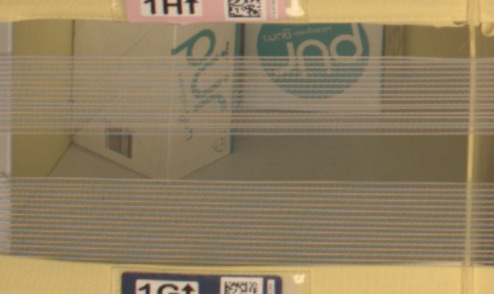

In [14]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [15]:
#https://www.geeksforgeeks.org/how-to-read-a-json-response-from-a-link-in-python/

from urllib.request import urlopen
import json

url = "https://aft-vbi-pds.s3.amazonaws.com/metadata/777.json"
response = urlopen(url)
data_json = json.loads(response.read())

print(data_json)

{'BIN_FCSKU_DATA': {'B0067EQF9I': {'asin': 'B0067EQF9I', 'height': {'unit': 'IN', 'value': 2.2}, 'length': {'unit': 'IN', 'value': 4.9}, 'name': 'PUR Gum Aspartame Free Wintergreen Gum, 9 Count (Pack of 12)', 'quantity': 3, 'weight': {'unit': 'pounds', 'value': 0.6}, 'width': {'unit': 'IN', 'value': 3.8}}}, 'EXPECTED_QUANTITY': 3, 'image_fname': '777.jpg'}


The metadata contains information about the objects in the bin such as the Amazon Standard Identification 
Number (ASIN), name, normalized name, quantity, weight and size [9]. It contains the expected quantity 
of objects in the bin. The images and their corresponding metadata will serve as inputs to the training 
algorithm. 

A random storage scheme is used where objects are stored in accessible bins with available space, therefore 
each bin's contents is random. Each bin image may show only one type of object or many different types 
of objects. If objects are misplaced the contents of some bin images may not match the inventory record 
[10].

In [16]:
#Plot hist of distribution of number of products in bin image subset

import json

with open('file_list.json') as json_data:
    data = json.load(json_data)

dict = {}

for key, value in data.items():
    dict[key] = len(value)

dict

{'1': 1228, '2': 2299, '3': 2666, '4': 2373, '5': 1875}

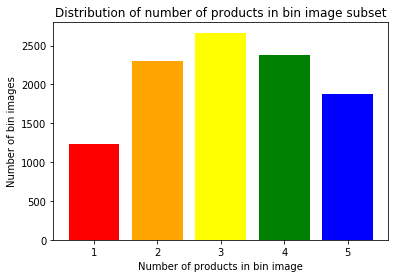

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure() 
plt.bar(dict.keys(), dict.values(), color=['red', 'orange', 'yellow','green', 'blue'])
plt.xlabel('Number of products in bin image')
plt.ylabel('Number of bin images')
plt.title('Distribution of number of products in bin image subset')
fig.savefig('bin_image_dist_rainbow.png') 

Due to the large size of the data, a small subset of the data will be used to stay within the allocated budget. 
The data subset contains 10441 bin images. The distribution of the number of products per bin in the data 
subset is shown above. The range of the number of products is from 1 to 5, therefore there are 5 classes. The most common 
number of products per bin is 3.

In [12]:
#TODO: Upload the data to AWS S3

session = sagemaker.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

prefix = "data"

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

#make sure u get a new bucket

Default Bucket: sagemaker-us-east-1-021284549365
AWS Region: us-east-1
RoleArn: arn:aws:iam::021284549365:role/service-role/AmazonSageMaker-ExecutionRole-20220208T235967


In [21]:
# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train_data s3://${DEFAULT_S3_BUCKET}/data/

upload: train_data/1/00009.jpg to s3://sagemaker-us-east-1-021284549365/data/1/00009.jpg
upload: train_data/1/00084.jpg to s3://sagemaker-us-east-1-021284549365/data/1/00084.jpg
upload: train_data/1/00014.jpg to s3://sagemaker-us-east-1-021284549365/data/1/00014.jpg
upload: train_data/1/00024.jpg to s3://sagemaker-us-east-1-021284549365/data/1/00024.jpg
upload: train_data/1/00048.jpg to s3://sagemaker-us-east-1-021284549365/data/1/00048.jpg
upload: train_data/1/00035.jpg to s3://sagemaker-us-east-1-021284549365/data/1/00035.jpg
upload: train_data/1/00237.jpg to s3://sagemaker-us-east-1-021284549365/data/1/00237.jpg
upload: train_data/1/00086.jpg to s3://sagemaker-us-east-1-021284549365/data/1/00086.jpg
upload: train_data/1/00152.jpg to s3://sagemaker-us-east-1-021284549365/data/1/00152.jpg
upload: train_data/1/00213.jpg to s3://sagemaker-us-east-1-021284549365/data/1/00213.jpg
upload: train_data/1/00148.jpg to s3://sagemaker-us-east-1-021284549365/data/1/00148.jpg
upload: train_data/1/

In [14]:
# Assign S3 paths for the training job

data_path = "s3://{}/{}/".format(bucket, "data")
output_path = "s3://{}/{}/".format(bucket, "output")
model_path = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= data_path
os.environ['SM_MODEL_DIR']= model_path
os.environ['SM_OUTPUT_DATA_DIR']= output_path

## Model Training
The `hpo.py` script was used to train the first model with the default hyperparameter values.

In [ ]:
#Declare model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values

#default hyperparameters = {"lr": 0.01,"batch_size": 64} 

In [16]:
#TODO: Create your training estimator

from sagemaker.pytorch import PyTorch

estimator1 = PyTorch(
    entry_point="hpo.py",
    base_job_name='abid-pytorch-fixed-hyp-model',
    role=role,
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

In [17]:
# TODO: Fit your estimator
estimator1.fit({"train": data_path}, wait=True) 

2022-02-10 18:33:37 Starting - Starting the training job...
2022-02-10 18:34:05 Starting - Launching requested ML instancesProfilerReport-1644518017: InProgress
.........
2022-02-10 18:35:25 Starting - Preparing the instances for training......
2022-02-10 18:36:25 Downloading - Downloading input data............
2022-02-10 18:38:37 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-10 18:38:38,104 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-02-10 18:38:38,125 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-10 18:38:41,138 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-10 18:38:41,515 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2022-02-10 18:38:41,516 sag

## Standout Suggestions

### Hyperparameter Tuning

Hyperparameters tuning was performed with the <code>hpo.py</code> script to find the best hyperparameters and improve the
model performance. The batch size and learning rate were tuned. The hyperparameters and their ranges were chosen because they are widely used in tuning. 

In [47]:
#TODO: Create your hyperparameter search space

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
} 

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [51]:
#TODO: Create your training estimator

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='abid-pytorch-hpo',
    role=role,
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

In [52]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [ ]:
# TODO: Fit your estimator
tuner.fit({"train": data_path}, wait=True) 

.......................................................................................

In [ ]:
#Lost connection 

### Tuning results

In [4]:
# TODO: Find the best hyperparameters

from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-220210-1911')   

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue')  

,batch_size,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""32""",0.003716,pytorch-training-220210-1911-004-9fe011d4,Completed,45.022911,2022-02-10 19:31:30+00:00,2022-02-10 19:41:26+00:00,596.0
2,"""32""",0.001078,pytorch-training-220210-1911-002-8f33db6c,Completed,45.033100,2022-02-10 19:14:06+00:00,2022-02-10 19:22:58+00:00,532.0
3,"""128""",0.012006,pytorch-training-220210-1911-001-824aa75b,Completed,184.644699,2022-02-10 19:15:45+00:00,2022-02-10 19:28:21+00:00,756.0
1,"""512""",0.039200,pytorch-training-220210-1911-003-839a6aa3,Completed,658.514343,2022-02-10 19:26:12+00:00,2022-02-10 19:36:05+00:00,593.0


In [9]:
BetterTrainingJobName='pytorch-training-220210-1911-004-9fe011d4'      

In [11]:
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)


2022-02-10 19:41:26 Starting - Preparing the instances for training
2022-02-10 19:41:26 Downloading - Downloading input data
2022-02-10 19:41:26 Training - Training image download completed. Training in progress.
2022-02-10 19:41:26 Uploading - Uploading generated training model
2022-02-10 19:41:26 Completed - Training job completed


In [14]:
my_estimator.hyperparameters()

{'_tuning_objective_metric': 'Test Loss',
 'batch_size': '"32"',
 'lr': '0.00371599290323504',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"abid-pytorch-hpo-2022-02-10-19-11-14-036"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-021284549365/abid-pytorch-hpo-2022-02-10-19-11-14-036/source/sourcedir.tar.gz"'}

In [13]:
best_estimator=my_estimator

<h3>Prepare to perform Training on Best Estimator</h3>

In [19]:
#best_estimator=tuner.best_estimator()

In [15]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': 'Test Loss',
 'batch_size': '"32"',
 'lr': '0.00371599290323504',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"abid-pytorch-hpo-2022-02-10-19-11-14-036"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-021284549365/abid-pytorch-hpo-2022-02-10-19-11-14-036/source/sourcedir.tar.gz"'}

In [16]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['lr']}
hyperparameters

{'batch_size': 32, 'lr': '0.00371599290323504'}

### Model Profiling and Debugging

SageMaker debugger and profiler were used to better monitor and debug the model training job. The <code>train.py</code> script was used to train the final model and perform model profiling and debugging.

In [17]:
# TODO: Set up debugging and profiling rules and hooks

from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

In [18]:
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)


collection_config = CollectionConfig(
    name='CrossEntropyLoss_output_0',
    parameters={
        'include_regex': 'CrossEntropyLoss_output_0'
    }
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "1"}, collection_configs=[collection_config]
)
    
   

In [19]:
# TODO: Create and fit an estimator

import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    role=role,
    base_job_name='abid-pytorch-best-hyp-model',
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [ ]:
estimator.fit({"train": data_path}, wait=True)

2022-02-10 20:01:15 Starting - Starting the training job...
2022-02-10 20:01:21 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-02-10 20:03:13 Starting - Preparing the instances for training......
2022-02-10 20:04:14 Downloading - Downloading input data............
2022-02-10 20:06:15 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-10 20:06:20,225 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-02-10 20:06:20,248 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-10 20:06:23,262 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-10 20:06:23,635 sage

In [23]:
# TODO: Plot a debugging output.

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

Training jobname: abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027


In [24]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-02-10 20:26:04.896 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-10 20:26:04.942 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-021284549365/abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/debug-output
[2022-02-10 20:26:05.529 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 212 more expected)', IncompleteRead(0 bytes read, 212 more expected)) while reading s3://sagemaker-us-east-1-021284549365/abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/debug-output/index/000000000/000000000238_worker_0.json . Will retry now


In [25]:
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-02-10 20:26:18.702 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-10 20:26:19.728 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_

In [26]:
#code from lesson4, 8 model_debugging
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [27]:
#code from lesson4, 8 model_debugging
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
    fig.savefig('CrossEntropyLoss_output_0_tensor.png')  #added

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


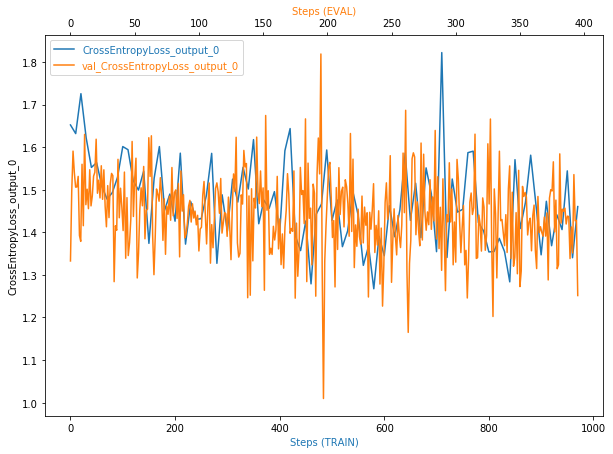

In [29]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

<b>Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?</b>  

<b>If not, suppose there was an error. What would that error look like and how would you have fixed it?</b>

The Cross - entropy loss is shown above. It is difficult to determine if the model is learning because
of the numerous oscillations. These are likely due to the small batch size [11] or outliers [12]. If a larger
batch size is used and the outliers are removed, the training curve may smooth out, and show a decrease in
loss, which indicates the model is learning. This maybe the case, as the training loss decreases from about
1.65 to 1.45, and the cross validation loss decreases from about 1.33 to 1.25.

However, if the training curve is still flat, it indicates that the model is not learning and the learning rate
needs to be changed. The number of input and output features, in the fully connected layers that were added
on, could be modified. If the training curve shows an increase in loss, it indicates that the model is diverging
and a smaller learning rate needs to be used. 

In [30]:
#Checking System Utilization

#training_job_name= 'abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027'

from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-021284549365/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-021284549365/abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/profiler-output


Profiler data from system is available


In [31]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-02-10 20:33:39.121 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO metrics_reader_base.py:134] Getting 11 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [32]:
# TODO: Display the profiler output

In [33]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-021284549365/abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/rule-output


In [34]:
! aws s3 ls {rule_output_path} --recursive

2022-02-10 20:14:07     383201 abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-10 20:14:06     234249 abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-10 20:14:01        558 abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-10 20:14:01       8461 abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-10 20:14:01        126 abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-10 20:14:01        326 abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-10 20:14:01       3480 abid-pytorch-best-hyp-model-2

In [35]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-021284549365/abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-021284549365/abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-021284549365/abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-021284549365/abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-02128

In [36]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


In [37]:
profiler_report_name

'ProfilerReport'

In [40]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying

Each model was deployed to an endpoint and then queried with images to make predictions. The <code>inference.py</code> script was used. 

#### Initial model

In [ ]:
#Initial model
#default hyperparameters = {"lr": 0.01, "batch_size": 64} 
#abid_pytorch_fixed_hyp_model
#'s3://sagemaker-us-east-1-021284549365/abid-pytorch-fixed-hyp-model-2022-02-10-18-33-37-046/output/model.tar.gz'

In [18]:
model_location1=estimator1.model_data

In [19]:
model_location1

's3://sagemaker-us-east-1-021284549365/abid-pytorch-fixed-hyp-model-2022-02-10-18-33-37-046/output/model.tar.gz'

In [20]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [21]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [23]:
pytorch_model1 = PyTorchModel(model_data=model_location1, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [24]:
predictor1 = pytorch_model1.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')


-------!

In [25]:
#Test with image 923.jpg, EXPECTED_QUANTITY: 4

import requests

request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/923.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

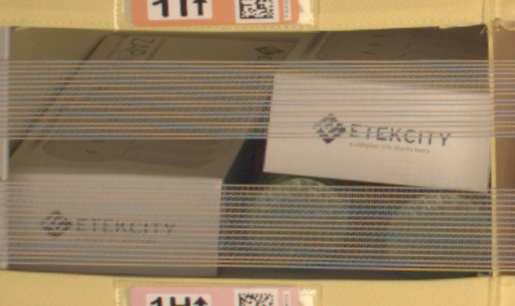

In [26]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [27]:
# TODO: Run a prediction on the endpoint

response=predictor1.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [29]:
response

[[-0.48211732506752014,
  0.08623732626438141,
  0.21010656654834747,
  0.14803989231586456,
  -0.0743698999285698]]

In [30]:
import numpy as np
np.argmax(response, 1)

array([2])

In [31]:
#Test with image 777.jpg, EXPECTED_QUANTITY: 3

import requests

request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/777.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

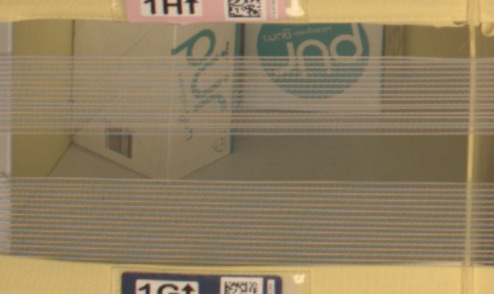

In [32]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [39]:
response=predictor1.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [40]:
response

[[-0.48211732506752014,
  0.08623732626438141,
  0.21010656654834747,
  0.14803989231586456,
  -0.0743698999285698]]

In [41]:
np.argmax(response, 1)

array([2])

In [42]:
import json
response2=predictor1.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [43]:
response2

[[-0.48211732506752014,
  0.08623732626438141,
  0.21010656654834747,
  0.14803989231586456,
  -0.0743698999285698]]

In [44]:
type(response2[0][0])

float

In [45]:
response2[0]

[-0.48211732506752014,
 0.08623732626438141,
 0.21010656654834747,
 0.14803989231586456,
 -0.0743698999285698]

In [46]:
np.argmax(response2[0])

2

In [ ]:
#endpoint 
#pytorch-inference-2022-02-10-18-54-04-687

In [18]:
#ground truth
#https://www.geeksforgeeks.org/how-to-read-a-json-response-from-a-link-in-python/

from urllib.request import urlopen
import json

url = "https://aft-vbi-pds.s3.amazonaws.com/metadata/923.json"
response = urlopen(url)
data_json = json.loads(response.read())

print(data_json)

{'BIN_FCSKU_DATA': {'B00D82JG48': {'asin': 'B00D82JG48', 'height': {'unit': 'IN', 'value': 2.3}, 'length': {'unit': 'IN', 'value': 9.11}, 'name': 'Garnier Fructis Fall Fight Shampoo For Falling Breaking Hair, 25.4 Fluid Ounce', 'quantity': 2, 'weight': {'unit': 'pounds', 'value': 1.8}, 'width': {'unit': 'IN', 'value': 3.54}}, 'B00DQELHBS': {'asin': 'B00DQELHBS', 'height': {'unit': 'IN', 'value': 2.5984251968503935}, 'length': {'unit': 'IN', 'value': 9.37007874015748}, 'name': 'Etekcity Wireless Remote Control Electrical Outlet Switch for Household Appliances (Learning Code, 5Rx-2Tx)', 'quantity': 2, 'weight': {'unit': 'pounds', 'value': 3.042348163678331}, 'width': {'unit': 'IN', 'value': 5.118110236220472}}}, 'EXPECTED_QUANTITY': 4, 'image_fname': '923.jpg'}


#### Final model

In [ ]:
#best hyperparameters = {'batch_size': 32, 'lr': '0.00371599290323504'}
#abid_pytorch_best_hyp_model
#s3://sagemaker-us-east-1-021284549365/abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/output/model.tar.gz

In [41]:
model_location=estimator.model_data

In [42]:
model_location

's3://sagemaker-us-east-1-021284549365/abid-pytorch-best-hyp-model-2022-02-10-20-01-15-027/output/model.tar.gz'

In [43]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [44]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [46]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [47]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')


--------!

In [48]:
#Test with 923.jpg, EXPECTED_QUANTITY: 4

import requests

request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/923.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

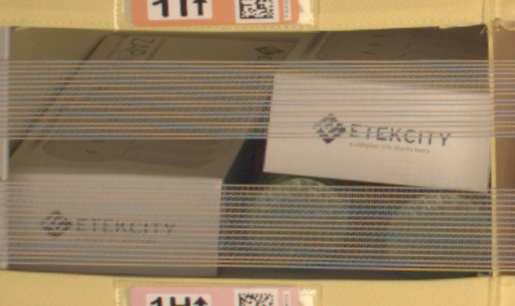

In [49]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [50]:
# TODO: Run a prediction on the endpoint

response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [51]:
response

[[-1.8109267950057983,
  0.2871607542037964,
  0.66116863489151,
  0.5736399292945862,
  0.3940010368824005]]

In [52]:
import numpy as np
np.argmax(response, 1)

array([2])

In [ ]:
#endpoint
#pytorch-inference-2022-02-10-20-37-37-843

In [53]:
#Test with 777.jpg, EXPECTED_QUANTITY: 3

import requests

request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/777.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

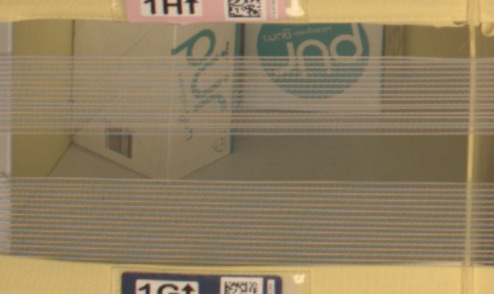

In [54]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [55]:
# TODO: Run a prediction on the endpoint

response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [56]:
response

[[2.741820812225342,
  1.6072783470153809,
  -0.2160869836807251,
  -2.114128589630127,
  -3.8471338748931885]]

In [57]:
np.argmax(response,1)

array([0])

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Multi-Instance Training

Multi-Instance GPU model training was performed with the <code>train_multi.py</code> script. The NVIDIA Collective Communication Library (NCCL) backend, torch.nn.DistributedDataParallel (DDP) and the best hyperparameters were used. Two instances of ml.g4dn.xlarge were used to save costs. 

In [15]:
# TODO: Train your model on Multiple Instances

hyperparameters = {'batch_size': 32, 'lr': '0.00371599290323504'}

estimator = PyTorch(
    entry_point='train_multi.py',
    base_job_name='abid-pytorch-multi',
    role=role,
    instance_count=2,   
    instance_type='ml.g4dn.xlarge' ,     
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
)

In [16]:
estimator.fit({"train": data_path}, wait=True)

2022-02-10 21:15:48 Starting - Starting the training job...
2022-02-10 21:16:11 Starting - Launching requested ML instancesProfilerReport-1644527747: InProgress
.........
2022-02-10 21:17:32 Starting - Preparing the instances for training......
2022-02-10 21:18:32 Downloading - Downloading input data............
2022-02-10 21:20:43 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-10 21:20:44,229 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-02-10 21:20:44,253 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-10 21:20:44,396 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-02-10 21:20:44,420 sagemaker_pytorch_

### References

[1] Redmon, J. & Farhadi, A. 2018. YOLOv3: An incremental improvement. arXiv preprint, arXiv1804.02767.

[2] Fu, C-Y., Liu, W., Ranga, A., Tyagi, A. & Berg, A.C. 2017. DSSD: Deconvolutional single shot detector. arXiv preprint,
arXiv:1701.06659.

[3] https://github.com/ultralytics/yolov5, Accessed 18/1/22.

[4] He, K., Zhang, X., Ren, S. and Sun, J., 2016. Deep residual learning for image recognition. In Proceedings of the IEEE
conference on computer vision and pattern recognition, pp. 770-778.

[5] He, T., Huang, W., Qiao, Y. and Yao, J., 2016. Text-attentional convolutional neural network for scene text detection. IEEE
transactions on image processing, 25(6), pp.2529-2541

[6] Chen, X., Xiang, S., Liu, C.L. and Pan, C.H., 2014. Vehicle detection in satellite images by hybrid deep convolutional neural
networks. IEEE Geoscience and remote sensing letters, 11(10), pp.1797-1801.

[7] https://classroom.udacity.com/nanodegrees/nd189/parts/cd0549/modules/864d3e12-dc8d-47c6-b443-
d01d6c7aedde/lessons/d6ec6005-e421-455c-9b79-ebc2df44e1ac/concepts/ad3d3503-f9a9-4c18-86ae-c03d6fbb1470, Accessed
18/1/22. 

[8] https://registry.opendata.aws/amazon-bin-imagery/, Accessed 18/1/22.

[9] https://github.com/silverbottlep/abid_challenge, Accessed 18/1/22.

[10] https://github.com/awslabs/open-data-docs/tree/main/docs/aft-vbi-pds, Accessed 18/1/22.

[11] https://stackoverflow.com/questions/68529287/why-does-my-learning-curves-shows-spikes-or-fluctuations, Accessed
10/1/22.

[12] https://stats.stackexchange.com/questions/303857/explanation-of-spikes-in-training-loss-vs-iterations-with-adam-optimizer,
Accessed 10/1/22.